# RGI12 (Caucasus and Middle East)

F. Maussion & F. Roura Adserias & S. Galos

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist
import os

## Files and storage paths

In [2]:
# Region of interest 
reg = 12

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '12_rgi60_CaucasusMiddleEast.zip')

# Specific to this region: boxes where data has to be selected differently
support_dir = os.path.join(data_dir, 'l0_support_data')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, _ = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
76,51,14.8,Nosenko,Khromova,2005,Siberian Mountains,2004,2004,2004
79,16,3.4,Nosenko,Khromova,2005,Siberian Mountains,2004,2004,2004
81,53,38.0,Nosenko,Khromova,2005,Siberian Mountains,2004,2004,2004
83,13,14.1,Nosenko,Khromova,2005,Siberian Mountains,2004,2004,2004
87,12,9.2,Nosenko,Khromova,2005,Siberian Mountains,2004,2004,2004
327,4,0.3,Khromova,Khromova,2006,Siberian Mountains,2001,2001,2001
341,463,340.3,Seliverstov,Khromova,2006,Siberian Mountains,2000,2000,2000
423,34,28.5,Nosenko,Khromova,2007,Siberian Mountains,2004,2004,2004
424,19,17.2,Nosenko,Khromova,2007,Russian Glaciers (exact boundaries of RC to be...,1999,1999,1999


Notes based on inidivual submission evaluations: 
- subm 76 to 429 are all in Caucasus (we don't use them because now have subm 724 there)
- subm 588 is Iran (looks like this was what was used for RGI6)
- subm 662 is Turkey (looks like this was what was used for RGI6)

In [5]:
# # Write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', 'rgi12_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi12_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), 'rgi12_inventories']))

### Apply selection criteria to create the RGI7 data subset

In [6]:
# for Caucasus we use 'subm_id' 724 by analyst 'Tielidze, Levan' which corresponds to the best and closest to 2000 
RGI_ss_caucasus = shp.loc[shp['subm_id'] == 724].copy()
RGI_ss_caucasus['is_rgi6'] = False

In [7]:
# for Middle East / Iran: 'subm_id' 588
RGI_ss_middle_east = shp.loc[shp['subm_id'] == 588].copy()
RGI_ss_middle_east['is_rgi6'] = True

In [8]:
# for Turkey: 'subm_id' 662
RGI_ss_Turkey = shp.loc[shp['subm_id'] == 662].copy()
RGI_ss_Turkey['is_rgi6'] = True

### Filter small glaciers 

In [9]:
print(len(RGI_ss_caucasus))
RGI_ss_caucasus = size_filter(RGI_ss_caucasus)
print(len(RGI_ss_caucasus))

2185
2182


In [10]:
print(len(RGI_ss_middle_east))
RGI_ss_middle_east = size_filter(RGI_ss_middle_east)
print(len(RGI_ss_middle_east))

484
203


In [11]:
print(len(RGI_ss_Turkey))
RGI_ss_Turkey = size_filter(RGI_ss_Turkey)
print(len(RGI_ss_Turkey))

51
46


In [12]:
# combine the three geodataframes
rgi7 = pd.concat([RGI_ss_caucasus, RGI_ss_middle_east, RGI_ss_Turkey])

### Some sanity checks 

In [13]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
724,2182,2182
588,203,203
662,46,46


In [14]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

### Plots 

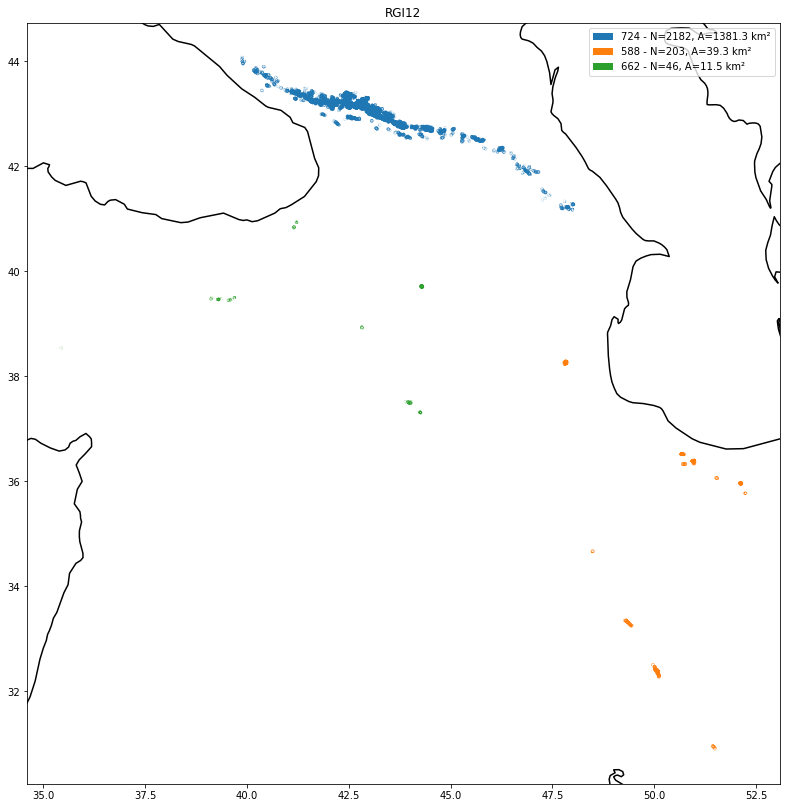

In [17]:
plot_map(rgi7, reg, linewidth=3)

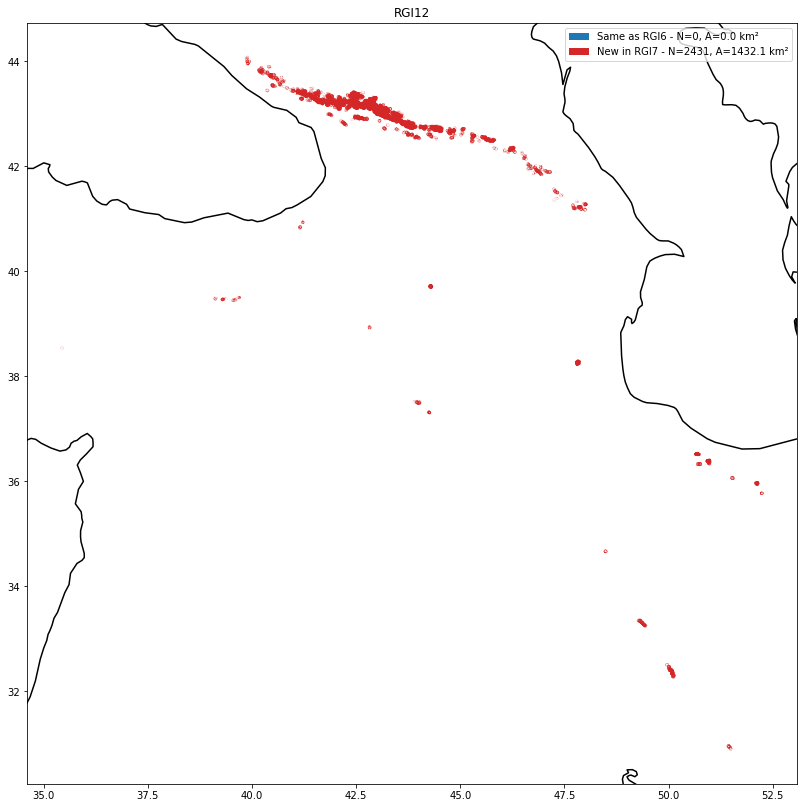

In [16]:
plot_map(rgi7, reg, linewidth=3, is_rgi6=True)

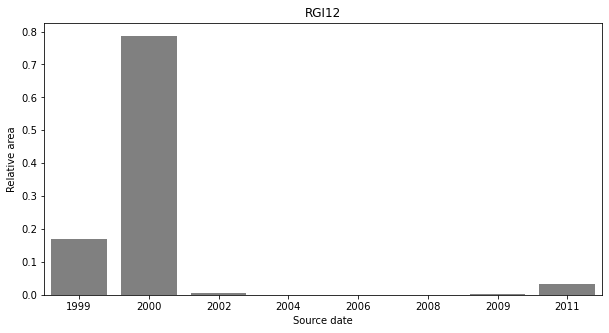

In [18]:
plot_date_hist(rgi7, reg)

### Text for github

In [19]:
fgh = sdf.T
fgh

subm_id,724,588,662
N,2182,203,46
A,1381.3,39.3,11.5
analysts,Tielidze,"Ashkan, Karimi, Sara",Sarikaya
submitters,Tielidze,Karimi,Sarikaya
release_date,2020,2015,2017
geog_area,Caucausus Region,Iran,Turkey
src_date_mode,2000,2011,2006
src_date_min,1999,2011,2004
src_date_max,2002,2011,2011


In [20]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 724              | 588                  | 662      |
|:--------------|:-----------------|:---------------------|:---------|
| N             | 2182             | 203                  | 46       |
| A             | 1381.3           | 39.3                 | 11.5     |
| analysts      | Tielidze         | Ashkan, Karimi, Sara | Sarikaya |
| submitters    | Tielidze         | Karimi               | Sarikaya |
| release_date  | 2020             | 2015                 | 2017     |
| geog_area     | Caucausus Region | Iran                 | Turkey   |
| src_date_mode | 2000             | 2011                 | 2006     |
| src_date_min  | 1999             | 2011                 | 2004     |
| src_date_max  | 2002             | 2011                 | 2011     |


## Write out and tar 

In [21]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI12.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI12'], returncode=0)


In [22]:
# combine the three geodataframes
RGI_ss = pd.concat([RGI_ss_caucasus, RGI_ss_middle_east, RGI_ss_Turkey])

## New RGI-file created - Check result!

### load reference data (here RGI6) to enable comparison

In [23]:
# load reference data
from utils import open_zip_shapefile
ref_odf = open_zip_shapefile(rgi6_reg_file)

## Compare new RGI7-file to RGI6

### Number of elements (differences do not necessarily depict major problems)

In [24]:
print('Number of glaciers in new RGI:', len(rgi7))
print('Number of glaciers in RGI6:', len(ref_odf))
print('Difference:', len(rgi7)-len(ref_odf))

Number of glaciers in new RGI: 2431
Number of glaciers in RGI6: 1888
Difference: 543


### How many nominal glaciers were there in RGI06-R12?

In [25]:
len(ref_odf.loc[ref_odf.Status == 2])

339

### Total area

In [26]:
# add an area field to RGI_ss and reference data
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area

In [27]:
# print and compare area values
Area_RGI = rgi7['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_RGI)
Area_ref = ref_odf['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 1432.073533926547
Area RGI6 [km²]: 1306.999710204219
Area difference [km²]: 125.07382372232814


### Here starts the comparison `RGI7a` with the original `Levan` dataset:  

The data is downloaded comes from https://zenodo.org/record/5116329#.YXqvaL9Byit

Download: https://zenodo.org/record/5116329/files/CAUCASUS_GLACIERS_2000_2020_Tielidze%20et%20al.%202021.zip?download=1

In [36]:
ref_df = []
for fname in ['CAU_GLAC_AZER_2000', 'CAU_GLAC_GEO_2000', 'CAU_GLAC_RUS_2000']:
    ref_df.append(open_zip_shapefile(os.path.join(support_dir, 'levan_2000.zip'), include_pattern=fname))
ref_df = pd.concat(ref_df)

ref_df = ref_df.to_crs(RGI_ss_caucasus.crs)

In [37]:
# add an area field to RGI_ss and reference data
RGI_ss_caucasus['area'] = RGI_ss_caucasus.to_crs({'proj':'cea'}).area
ref_df['area'] = ref_df.to_crs({'proj':'cea'}).area

In [38]:
# Select by size
print(len(ref_df))
ref_df = ref_df.loc[np.round(ref_df['area'] * 1e-6, 3) >= 0.01]
print(len(ref_df))

2186
2183


We compare to the caucasus RGI only:

In [39]:
print('Number of glaciers in new RGI7 subset:', len(RGI_ss_caucasus))
print('Number of glaciers in reference data (lev):', len(ref_df))
print('Difference:', len(RGI_ss_caucasus)-len(ref_df))

Number of glaciers in new RGI7 subset: 2182
Number of glaciers in reference data (lev): 2183
Difference: -1


In [40]:
# print and compare area values
Area_RGI = RGI_ss_caucasus['area'].sum() * 1e-6
print('Area RGI [km²]:', Area_RGI)
Area_lev = ref_df['area'].sum() * 1e-6
print('Area Ref (lev) [km²]:', Area_lev)
d = (Area_RGI - Area_lev)
print('Area difference [km²]:', d)

Area RGI [km²]: 1381.2958167278275
Area Ref (lev) [km²]: 1381.4375931809755
Area difference [km²]: -0.14177645314794063


### Find the missing glacier 

In [41]:
from utils import haversine
import progressbar

# Make a copy of the data
df_ref = ref_df.copy()
rgi7 = RGI_ss_caucasus.copy()

# Prepare the data
def xy_coord(geom):
    """To compute CenLon CenLat ourselves"""
    x, y = geom.xy
    return x[0], y[0]

# compute CenLon CenLat ourselves
rp = df_ref.representative_point()
coordinates = np.array(list(rp.apply(xy_coord)))
df_ref['CenLon'] = coordinates[:, 0]
df_ref['CenLat'] = coordinates[:, 1]

rp = rgi7.representative_point()
coordinates = np.array(list(rp.apply(xy_coord)))
rgi7['CenLon'] = coordinates[:, 0]
rgi7['CenLat'] = coordinates[:, 1]

In [42]:
# Start with the easy cases
df_ref_orig = df_ref.copy()
# Compute the distance to the next closest
distances = np.empty_like(rgi7.CenLon.values)
other_id = np.empty(len(rgi7.CenLon.values), dtype=int)
area_other = np.empty_like(rgi7.CenLon.values)
for i, (ref_area, lon, lat) in progressbar.progressbar(enumerate(zip(rgi7['area'].values, rgi7.CenLon.values, rgi7.CenLat.values)), max_value=len(rgi7)):
    dist = (lon - df_ref.CenLon.values)**2 + (lat - df_ref.CenLat.values)**2 
    id0 = np.argsort(dist)[0]
    distances[i] = dist[id0]
    other_id[i] = id0
    s6 = df_ref.iloc[id0]
    area_other[i] = s6['area']

rgi7['distance'] = distances
rgi7['other_id'] = other_id
rgi7['area_other'] = area_other

100% (2182 of 2182) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


In [43]:
rgi7['distance'].mean(), rgi7['distance'].std()

(6.424161820367166e-08, 2.7168145182984655e-06)

In [44]:
not_ok = rgi7.loc[rgi7['distance'] >  (rgi7['distance'].mean() + rgi7['distance'].std())]

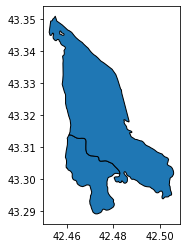

In [45]:
not_ok.plot(edgecolor='k');

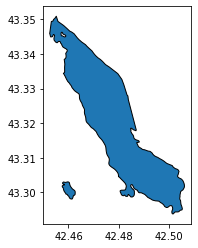

In [46]:
df_ref.iloc[not_ok.other_id].plot(edgecolor='k');

Email from Levan:

This error is due to different views on the definition of the margins of the Garabashi Glacier.

While working on our preprint, I was advised by Russian colleagues to modify the margins of Garabashi Glacier (and thus Azay and Terskol as neighbouring glaciers) before submitting to Zenodo. Mind you, that the database was already submitted to GLIMS at that time .

The Russian colleagues considered it important to keep the glacier boundaries in our Zenodo database consistent with in-situ measurements because Garabashi is one of the representative glaciers in the WGMS and this will be important for future comparisons (e.g. glaciological mass balance vs geodetic one).

To conclude, the outlines of Garabashi, Azay, and Terskol glaciers are more comprehensive in Zenodo (see attached) than those in GLIMS. However, the rest of the glaciers in both databases are the same.

I know, this sounds a bit annoying, but perhaps Bruce wants to replace them in GLIMS database as well? If so, I'm attaching the shp file of just those three glaciers.
Sorry Bruce about it, but this was not only my fault :) and thank you Fabien again for pointing this out.

### OK. Rest of the checks 

In [47]:
RGI_ss_Turkey.CenLat.max(), RGI_ss_caucasus.CenLat.min()

(40.935553999999996, 41.16944)

Perfect, we can just separate the RGI6 based on that.

In [48]:
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [49]:
new = pd.concat([RGI_ss_middle_east, RGI_ss_Turkey])
rgi6 = rgi6.loc[rgi6.CenLat < 41]
rgi6['area'] = rgi6.to_crs({'proj':'cea'}).area

In [50]:
print('Number of glaciers in new RGI7 subset:', len(new))
print('Number of glaciers in reference data (RGI6):', len(rgi6))
print('Difference:', len(new)-len(rgi6))

Number of glaciers in new RGI7 subset: 249
Number of glaciers in reference data (RGI6): 251
Difference: -2


In [51]:
# print and compare area values
Area_RGI7 = new['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_RGI7)
Area_RGI6 = rgi6['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_RGI6)
d = (Area_RGI7 - Area_RGI6)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 50.77771719871948
Area RGI6 [km²]: 51.36586023337505
Area difference [km²]: -0.5881430346555732


OK we can live with that. 